In [14]:
import numpy as np 
import uproot 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sys

#Drop Mass because all 0

In [15]:
import pandas as pd
#Columns names that are always the same for this data
columns = ['Event Number','Topocluster number','time', 'clusterSize', 'eta0', 'phi0', 'rawE', 'rawEta', 'rawPhi',
           'rawM','altE', 'altEta', 'altPhi', 'altM', 'calE', 'calEta', 'calPhi', 'calM', 'N_BAD_CELLS', 'SIGNIFCANCE',
           'ENG_FRAC_MAX', 'FIRST_ENG_DENS', 'ISOLATION', 'LATERAL', 'LONGITUDINAL', 'SECOND_LAMBDA', 'SECOND_R',
           'CENTER_LAMBDA', 'AVG_LAR_Q', 'CENTER_MAG', 'AVG_TITLE_Q', 'BADLARQ_FRAC', 'CELL_SIGNIFICANCE',
           'CELL_SIG_SAMPLING', 'BadChannelList', 'ENG_BAD_CELLS', 'ENG_POS', 'EM_PROBABILITY']
#File is delimited by *, last line is ****..., python engine must be used to use skipfooter
data = pd.read_csv('../raw_data/ryan_v2_fixed.dat',delimiter = '*', header = None, names = columns, skipfooter=1, index_col=False, engine='python')


print(columns)

['Event Number', 'Topocluster number', 'time', 'clusterSize', 'eta0', 'phi0', 'rawE', 'rawEta', 'rawPhi', 'rawM', 'altE', 'altEta', 'altPhi', 'altM', 'calE', 'calEta', 'calPhi', 'calM', 'N_BAD_CELLS', 'SIGNIFCANCE', 'ENG_FRAC_MAX', 'FIRST_ENG_DENS', 'ISOLATION', 'LATERAL', 'LONGITUDINAL', 'SECOND_LAMBDA', 'SECOND_R', 'CENTER_LAMBDA', 'AVG_LAR_Q', 'CENTER_MAG', 'AVG_TITLE_Q', 'BADLARQ_FRAC', 'CELL_SIGNIFICANCE', 'CELL_SIG_SAMPLING', 'BadChannelList', 'ENG_BAD_CELLS', 'ENG_POS', 'EM_PROBABILITY']


# Scaling the Data
Wulff Method: pt = log(pt)
                E = log(E)
                eta = eta/3
                phi = phi/3

In [16]:

#Just Looking at the fourvector
data = data.loc[:,['rawE','rawEta','rawPhi']]
#Cutting off energy that is greater that 90GeV
data = data[data['rawE']<4e5]
data[data.columns] = MinMaxScaler().fit_transform(data)

display(data)

,rawE,rawEta,rawPhi
0,0.318874,0.810164,0.648269
1,0.049307,0.440592,0.132695
2,0.048876,0.426909,0.137442
3,0.043437,0.442921,0.145152
4,0.250851,0.068230,0.201353
...,...,...,...
212329,0.028503,0.527605,0.085739
212330,0.028328,0.418684,0.522492
212331,0.027736,0.344663,0.014882
212332,0.028420,0.512209,0.782099


# Plotting the initial Data

rawE


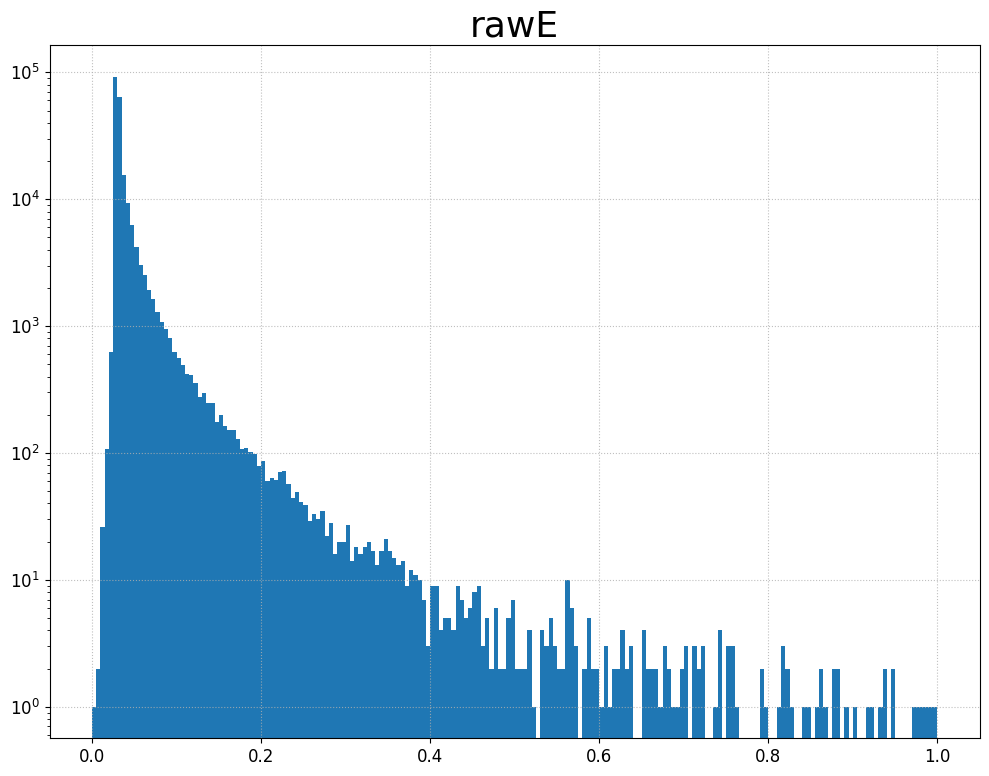

rawEta


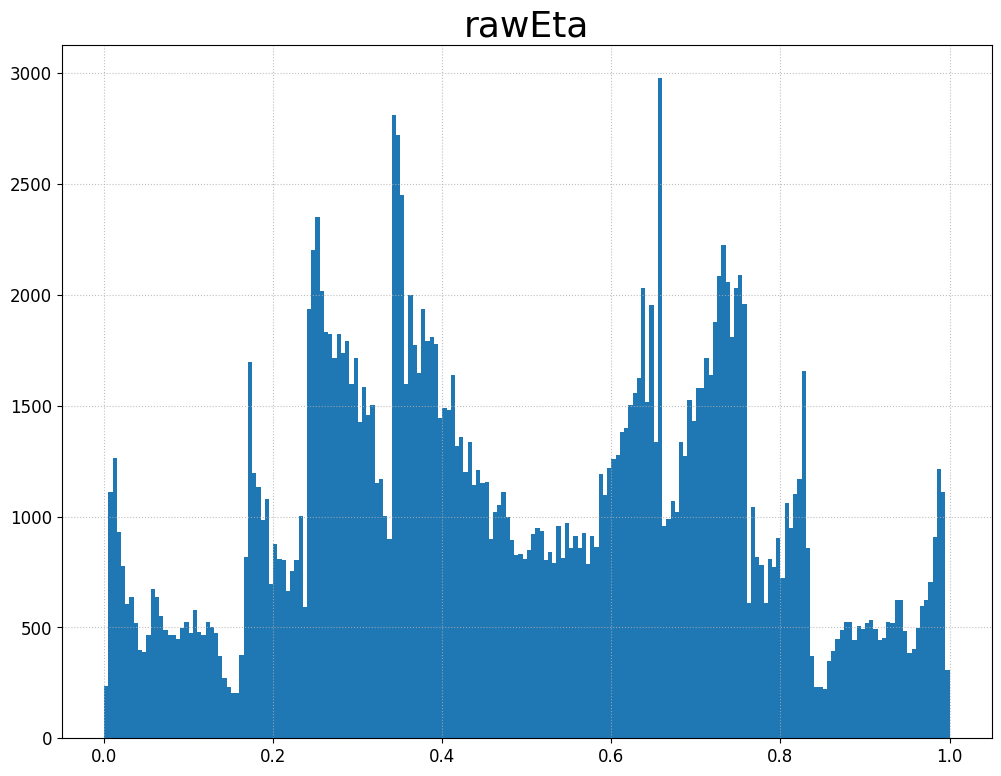

rawPhi


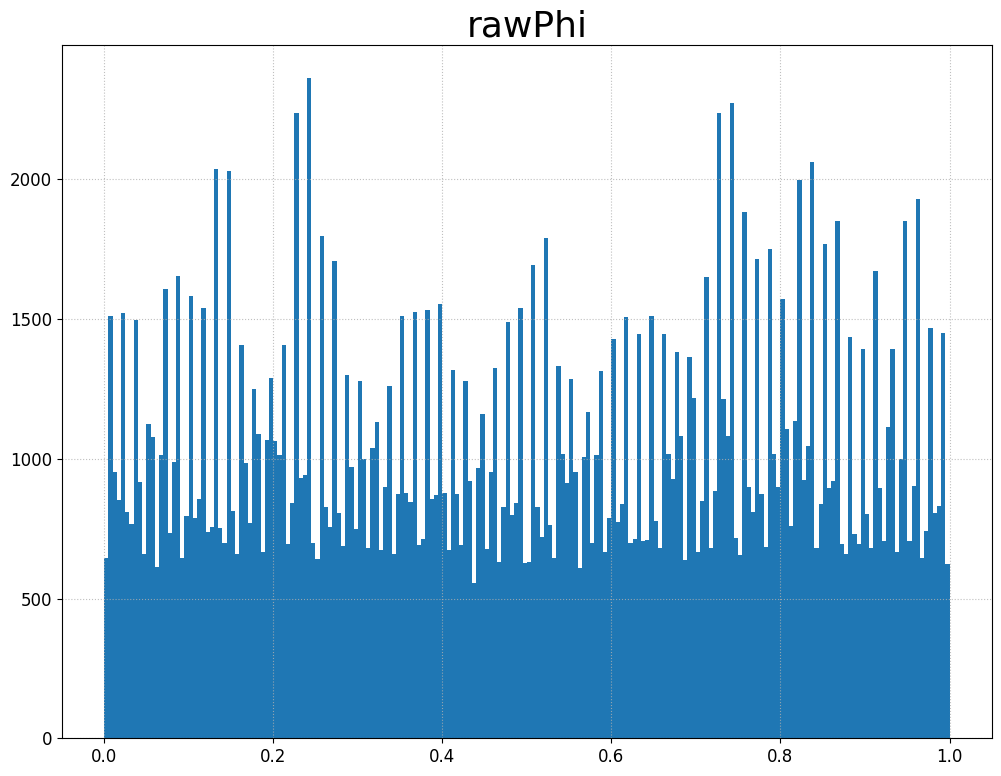

<Figure size 1200x900 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
#Creating Histograms for the data
for col in data.columns:
    if col == 'rawE':
        plt.yscale('log')
    plt.hist(data[col],bins = 200)
    plt.title(col)
    print(col)
    plt.show()
    plt.savefig(f'../plots/{col}_hist')
    
    plt.clf()

#The plots look alright. However, the weird domains suggest extraneous data.







# Looking for Extraneous Data 

# To Do 
1. Tryout different ways to scale data
    1. MinMax (Done)
    2. Wulff way
2. Try to find better learning rate and batch size? (Done)
3. Try adding uncertainty

In [18]:
import torch.nn as nn
class AE_Uncertainty(nn.Module):
    def __init__(self, n_features, latent, neurons, act, droprate=0.05):
        super(AE_Uncertainty, self).__init__()
        self.dp = nn.Dropout(droprate)
        self.en1 = nn.Linear(n_features, neurons[0])
        self.en2 = nn.Linear(neurons[0],neurons[1])
        self.en3 = nn.Linear(neurons[1],latent)
        #self.en4 = nn.Linear(neurons[2],latent)
        self.de1 = nn.Linear(latent, neurons[1])
        self.de2 = nn.Linear(neurons[1], neurons[0])
        self.de3 = nn.Linear(neurons[0],n_features)
        #self.de4 = nn.Linear(neurons[0], n_features)
        self.act = act
        
    def encode(self, x):
        x = self.act(self.en1(x))
        x = nn.Dropout(0.05)(x)
        x = self.act(self.en2(x))
        x = nn.Dropout(0.05)(x)
        x = self.en3(x)
        output = nn.Dropout(0.05)(x)
        return output
    
    def decode(self,x):
        x = self.de1(self.act(x))
        x = nn.Dropout(0.05)(x)
        x = self.de2(self.act(x))
        x = nn.Dropout(0.05)(x)
        output = self.de3(self.act(x))
        return output
                          
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)


    


In [19]:
def plot_epistemic_uncertainty(trained_model, data, T=500):
    predictions = []
    for _ in range(T):
        predictions += [trained_model(data).detach().numpy()]
    #print("These are the predictions: ")
    #print(predictions)
 
    std = []
    
    #Accessing each prediction should be 500
    for b in range(3): 
        data_std = np.zeros(len(predictions[0]))
        for i in range(len(predictions[0])):
            #Loops through all n data points
            std_values = []
            for a in range(len(predictions)):
                #grabs nth value in each prediction for eta,E or phi
                data_point = predictions[a][i][b]
                std_values += [data_point]
                #print(data_point)
            #print(len(std_values))    
            std_points = np.std(std_values)
            data_std[i] = std_points
        std.append(data_std)
            
            
            
            
    
    
    #This should be 1
    return std[0], std[1], std[2]

    
    
        

In [20]:
import model_functions as mf
import Plotting_AE
import Wulff_Functions

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#Try different transforms of the data


data = shuffle(data)
train_x, test_x = train_test_split(data, test_size=0.2, random_state=1)
train_y = train_x
test_y = test_x
print(train_x.values)
#Test_x is  a numpy array??
#Output type is the same as the input type
print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)
#The final data looks different because of this split
data = torch.tensor(test_x.values, dtype=torch.float)
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

[[0.03028437 0.75528036 0.98215122]
 [0.05550589 0.92952969 0.53279063]
 [0.04336124 0.08997209 0.36343916]
 ...
 [0.0296939  0.36891763 0.03980457]
 [0.0294995  0.42424508 0.8666672 ]
 [0.02941445 0.63809576 0.47477823]]
Train data shape: 
(169793, 3)
Test data shape: 
(42449, 3)


In [21]:
bs = 512 #Initially set at 256, Trying 500, 1000, 100
##512 is the first to not give spikes
# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)
dls = core.DataLoaders(train_dl, valid_dl)


In [22]:
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *

loss_function = nn.MSELoss()
weight_decay = 1e-6


Just Try and implement dropout model in this code

2 [100, 50] LeakyReLU(negative_slope=0.01)


epoch,train_loss,valid_loss,time
0,0.010464,0.008412,00:03
0,0.010464,0.008412,00:03
1,0.006175,0.005975,00:03
1,0.006175,0.005975,00:03
2,0.003644,0.004525,00:03
2,0.003644,0.004525,00:03
3,0.003334,0.002791,00:03
3,0.003334,0.002791,00:03
4,0.002850,0.002908,00:04
4,0.002850,0.002908,00:04


39.19725537596969


tensor([[0.0408, 0.7805, 0.7758],
        [0.0271, 0.4975, 0.3270],
        [0.0305, 0.3542, 0.7783],
        ...,
        [0.0285, 0.6137, 0.3262],
        [0.0315, 0.6714, 0.3331],
        [0.0299, 0.3582, 0.0788]], grad_fn=<AddmmBackward>)
[[0.04082655 0.7805381  0.7757865 ]
 [0.02713485 0.49745077 0.32697818]
 [0.03049406 0.35415888 0.77830017]
 ...
 [0.02850499 0.61366427 0.32621968]
 [0.03149942 0.6713911  0.33314842]
 [0.02987288 0.3581742  0.07879522]]
[[0.02946548 0.75729924 0.7445769 ]
 [0.03039615 0.46311083 0.3080896 ]
 [0.02977165 0.35310304 0.7740364 ]
 ...
 [0.02944118 0.63920397 0.3367339 ]
 [0.02901594 0.69992405 0.35568538]
 [0.0299328  0.34420457 0.0134143 ]]


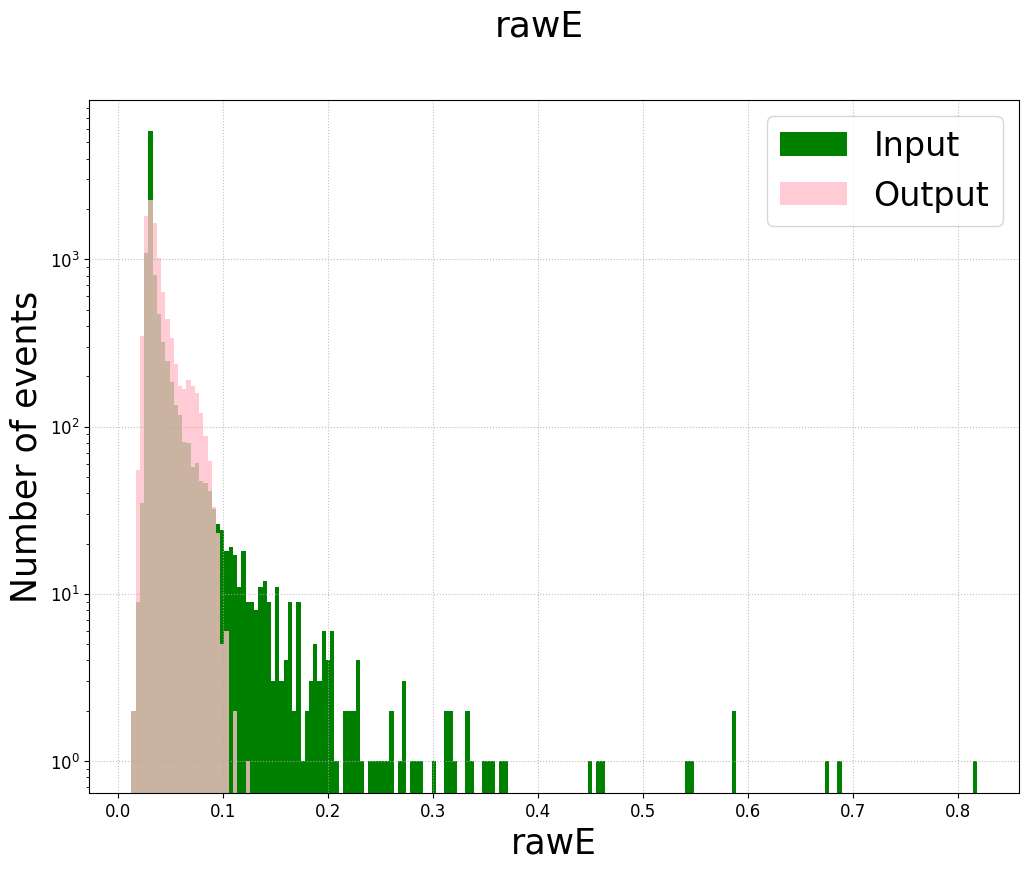

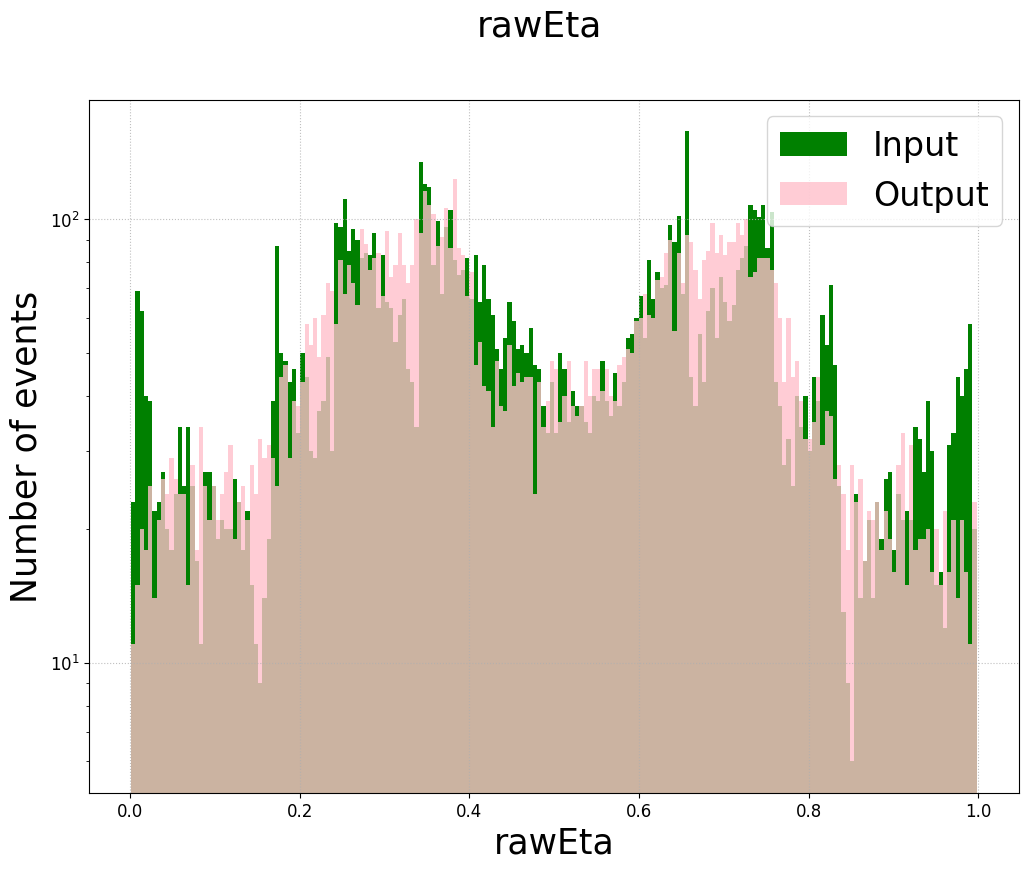

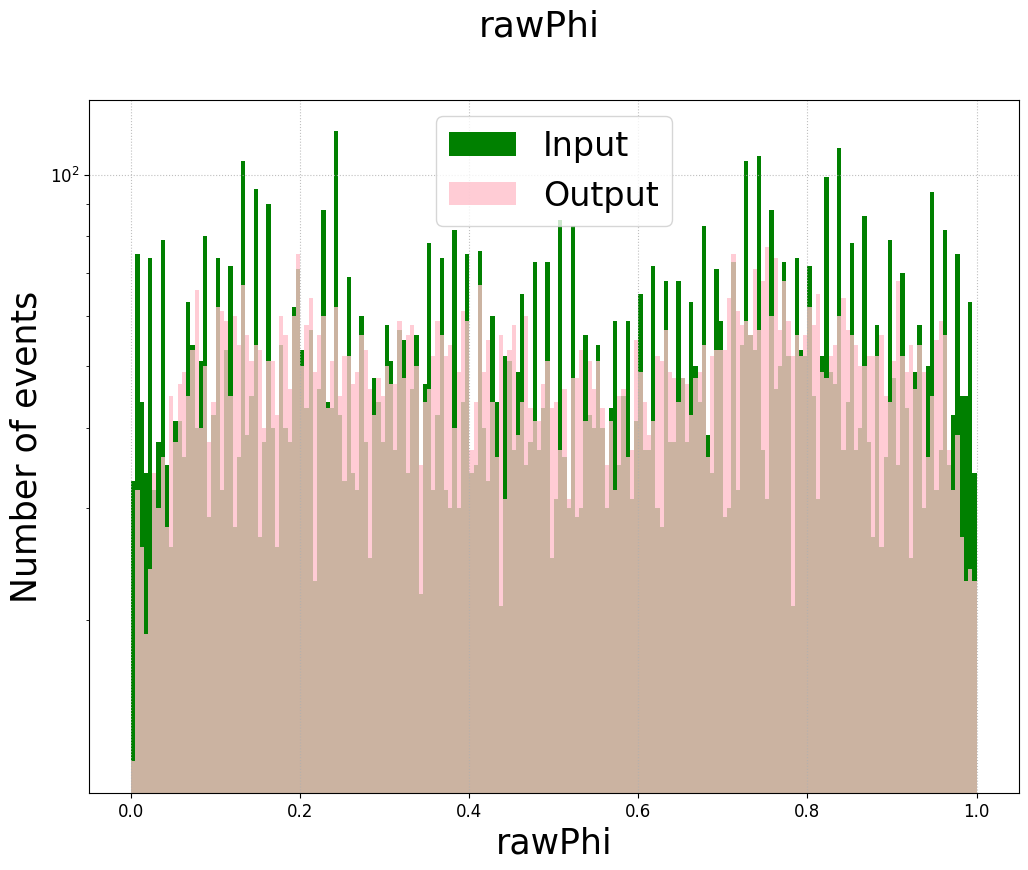

In [23]:
from Plotting_AE import *
from model_functions import *
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *
import time
from fastai.callback import schedule
import os
import shutil
import Wulff_Functions as wu

#Multiply to get total number of combinations
loss_function = nn.MSELoss()
weight_decay = 1e-6


latent_space = [2]
neurons_list = [[100,50]]
act_list = [nn.LeakyReLU()]

#This takes all the arguments given above and loops over all possible arrangements
#For some reason this part of the code does not work within a function
for x,y,z in [(x,y,z) for x in latent_space for y in neurons_list for z in act_list]:
    print(x,y,z)
    model = AE_Uncertainty(3,x,y,z)
    #This would already be defined
    #Putting recorder and learn outside of loop messes everything up
    recorder = learner.Recorder()
    learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)
    start = time.perf_counter() # Starts timer
    # train our autoencoder for 100 epochs
    learn.fit_one_cycle(10, 0.0209)
    end = time.perf_counter() # Ends timer
    delta_t = end - start
    print(delta_t)
    z = str(z)
    n1,n2 = tuple(y)
    save_dir = f'../plots/{n1}-{n2}-{x}__{z[0:9]}_lr:0.0209_bs:256_trigger_MinMax'
    
    #Creates a folder containing the plot_loss, validation, time if it doesn't already exist.
    #If the folder already exists, the program deletes the folder and recreates it.d
    #os.mkdir(save_dir)
#try:
        #os.mkdir(save_dir)
    #except FileExistsError:
       # shutil.rmtree(save_dir)
   #finally:
        #os.mkdir(save_dir)
    
    
    #Plotting Loss and recording validation and time
    recorder.plot_loss()
    #plt.savefig(os.path.join(save_dir,'_loss'), format='png')
    plt.clf()
    val = learn.validate()
    val =str(val)
    valid_time_file = save_dir + '/valid_time'
    #f = open(valid_time_file,'w')
    #f.write("Validation Error: ")
    #f.write(val)
   # f.write('\n')
   # f.write(str(delta_t))
   # f.close()
    
    #Plotting Final Results
    plt.clf
    plt.close('all')
    unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
    line_style = ['--', '-']
    colors = ['pink', 'green']
    markers = ['*', 's']

    model.to('cpu')
    save = False
    idxs = (0, 10000)  # Choose events to compare
    data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)

    pred = model(data)
    print(pred)
    pred = pred.detach().numpy()
    print(pred)
    data = data.detach().numpy()
    
    data_df = pd.DataFrame(data, columns=test_x.columns)
    pred_df = pd.DataFrame(pred, columns=test_x.columns)
    print(data)
    alph = 0.8
    n_bins = 200
    
    #Graphing uncertainty
    
    E_std, Eta_std, Phi_std = plot_epistemic_uncertainty(model, data)
    #Plotting output data
    for kk in np.arange(3):
        plt.figure()
        n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
        n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
        plt.errorbar(pred[:,kk],)
        plt.suptitle(test_x.columns[kk])
        plt.xlabel(test_x.columns[kk])
        plt.ylabel('Number of events')
        # ms.sciy()

        plt.yscale('log')
        if save:
            plt.savefig(os.path.join(save_dir,test_x.columns[kk] + '.png'))
        plt.legend()
    
    

100,50 LeakyReLU for 2 lat
100,10 Leaky


In [24]:

data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)
x =plot_epistemic_uncertainty(model, data)
print(x)



[array([0.00491044, 0.00337107, 0.00499548, ..., 0.00299549, 0.00352154,
       0.00500938]), array([0.03113791, 0.05532815, 0.035776  , ..., 0.02432171, 0.03492036,
       0.03373772]), array([0.03750212, 0.03872503, 0.0459468 , ..., 0.02381357, 0.02493837,
       0.05530899])]


In [25]:
data_df.isnull().values.any()

False

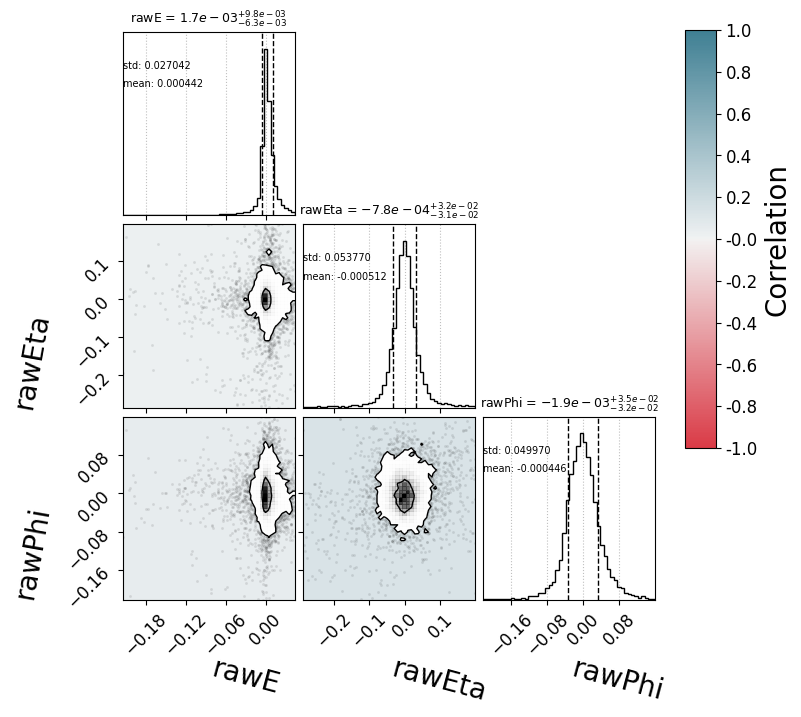

In [26]:
rel_diff_list = ['rawE', 'rawEta', 'rawPhi']
corner_groups = [rel_diff_list]
wu.corr_matrix(3,1,'./corr_Wulff',pred_df,data_df,rel_diff_list,corner_groups, save=True)